In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import json
import datetime
from dateutil.relativedelta import relativedelta
import gensim
from gensim import corpora, models
from gensim.models import Phrases
import numpy as np
import matplotlib.pyplot as plt
import random
import nltk
nltk.download('wordnet')
from nltk import FreqDist
from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,roc_curve,auc

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import Data

In [2]:
with open("C:/Users/hp/Desktop/Python_Code/jupyter_notebook/aclImdb/train-pos.txt",'r') as infile:
    positive=infile.readlines()

In [3]:
pos_review=[doc.decode("utf8") for doc in positive]

In [4]:
with open("C:/Users/hp/Desktop/Python_Code/jupyter_notebook/aclImdb/train-neg.txt",'r') as infile:
    negative=infile.readlines()

In [5]:
neg_review=[doc.decode("utf8") for doc in negative]

In [6]:
print(len(pos_review))
print(len(neg_review))

12500
12500


Lets review data

In [7]:
pos_review[0]

u'bromwell high is a cartoon comedy .  it ran at the same time as some other programs about school life ,  such as  " teachers "  .  my 35 years in the teaching profession lead me to believe that bromwell high\'s satire is much closer to reality than is  " teachers "  .  the scramble to survive financially ,  the insightful students who can see right through their pathetic teachers\' pomp ,  the pettiness of the whole situation ,  all remind me of the schools i knew and their students .  when i saw the episode in which a student repeatedly tried to burn down the school ,  i immediately recalled  .  .  .  .  .  .  .  .  .  at  .  .  .  .  .  .  .  .  .  .  high .  a classic line :  inspector :  i\'m here to sack one of your teachers .  student :  welcome to bromwell high .  i expect that many adults of my age think that bromwell high is far fetched .  what a pity that it isn\'t ! \n'

In [8]:
neg_review[0]

u"story of a man who has unnatural feelings for a pig .  starts out with a opening scene that is a terrific example of absurd comedy .  a formal orchestra audience is turned into an insane ,  violent mob by the crazy chantings of it's singers .  unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting .  even those from the era should be turned off .  the cryptic dialogue would make shakespeare seem easy to a third grader .  on a technical level it's better than you might think with some good cinematography by future great vilmos zsigmond .  future stars sally kirkland and frederic forrest can be seen briefly . \n"

In [9]:
total_reviews=pos_review+neg_review

In [10]:
punctuation = ".,?!:;(){}[]"
for c in punctuation:
    total_reviews = [z.replace(c, ' %s '%c) for z in total_reviews]    

In [11]:
total_reviews[0]

u'bromwell high is a cartoon comedy  .   it ran at the same time as some other programs about school life  ,   such as  " teachers "   .   my 35 years in the teaching profession lead me to believe that bromwell high\'s satire is much closer to reality than is  " teachers "   .   the scramble to survive financially  ,   the insightful students who can see right through their pathetic teachers\' pomp  ,   the pettiness of the whole situation  ,   all remind me of the schools i knew and their students  .   when i saw the episode in which a student repeatedly tried to burn down the school  ,   i immediately recalled   .    .    .    .    .    .    .    .    .   at   .    .    .    .    .    .    .    .    .    .   high  .   a classic line  :   inspector  :   i\'m here to sack one of your teachers  .   student  :   welcome to bromwell high  .   i expect that many adults of my age think that bromwell high is far fetched  .   what a pity that it isn\'t  !  \n'

In [12]:
word_token=[doc.lower().replace('\n','').replace('<br />','').strip().split() for doc in total_reviews]
word_token[:5]

[[u'bromwell',
  u'high',
  u'is',
  u'a',
  u'cartoon',
  u'comedy',
  u'.',
  u'it',
  u'ran',
  u'at',
  u'the',
  u'same',
  u'time',
  u'as',
  u'some',
  u'other',
  u'programs',
  u'about',
  u'school',
  u'life',
  u',',
  u'such',
  u'as',
  u'"',
  u'teachers',
  u'"',
  u'.',
  u'my',
  u'35',
  u'years',
  u'in',
  u'the',
  u'teaching',
  u'profession',
  u'lead',
  u'me',
  u'to',
  u'believe',
  u'that',
  u'bromwell',
  u"high's",
  u'satire',
  u'is',
  u'much',
  u'closer',
  u'to',
  u'reality',
  u'than',
  u'is',
  u'"',
  u'teachers',
  u'"',
  u'.',
  u'the',
  u'scramble',
  u'to',
  u'survive',
  u'financially',
  u',',
  u'the',
  u'insightful',
  u'students',
  u'who',
  u'can',
  u'see',
  u'right',
  u'through',
  u'their',
  u'pathetic',
  u"teachers'",
  u'pomp',
  u',',
  u'the',
  u'pettiness',
  u'of',
  u'the',
  u'whole',
  u'situation',
  u',',
  u'all',
  u'remind',
  u'me',
  u'of',
  u'the',
  u'schools',
  u'i',
  u'knew',
  u'and',
  u'their',


In [13]:
len(word_token)

25000

In [14]:
en_stop= get_stop_words(language='en')
custom_stop=['.',',',':','(',')','{','}','[',']']
en_stop=en_stop+custom_stop+['can','will','shall']

In [15]:
stopped_tokens=[[token for token in doc if not token in en_stop and not token.isdigit()]for doc in word_token]

In [16]:
wnl = WordNetLemmatizer()
texts= [[wnl.lemmatize(token) for token in doc]for doc in stopped_tokens]

In [17]:
texts[0][0:20]

[u'bromwell',
 u'high',
 u'cartoon',
 u'comedy',
 u'ran',
 u'time',
 u'program',
 u'school',
 u'life',
 u'"',
 u'teacher',
 u'"',
 u'year',
 u'teaching',
 u'profession',
 u'lead',
 u'believe',
 u'bromwell',
 u"high's",
 u'satire']

In [18]:
bigram = Phrases(texts, min_count=10,threshold=4)
trigram = Phrases(bigram[texts],min_count=10,threshold=4)
texts_1=list(trigram[bigram[texts]])

In [19]:
texts_1[0][0:20]

[u'bromwell',
 u'high',
 u'cartoon',
 u'comedy',
 u'ran',
 u'time',
 u'program',
 u'school',
 u'life',
 u'"',
 u'teacher',
 u'"',
 u'year',
 u'teaching',
 u'profession',
 u'lead_believe',
 u'bromwell',
 u"high's",
 u'satire',
 u'much_closer']

In [20]:
tf_matrix = defaultdict(int)

## token count in corpus
for text in texts_1:
     for token in text:
         tf_matrix[token] += 1

In [21]:
tf_matrix.items()

[(u'fawn', 3),
 (u'tsukino', 1),
 (u'nunnery', 1),
 (u"zuniga's", 1),
 (u'waiting_something', 13),
 (u'sonja', 13),
 (u'bottom_list', 12),
 (u'post-cabaret', 1),
 (u"'wake-up'", 1),
 (u'hanging', 179),
 (u'woody', 76),
 (u'trawling', 1),
 (u'ctomvelu', 1),
 (u'comically', 24),
 (u'non-professionals--a', 2),
 (u'localized', 2),
 (u'disobeying', 4),
 (u'yougoslavia', 1),
 (u"harpo's", 2),
 (u'canet', 1),
 (u"boop's", 2),
 (u'factoring', 1),
 (u'jell-o', 4),
 (u"diplomat's", 1),
 (u'gaa', 1),
 (u'rickman', 6),
 (u'rumbustious', 1),
 (u'familiarness', 1),
 (u"spider'", 1),
 (u"wood'", 1),
 (u'transvestism', 2),
 (u'flame-effects', 1),
 (u"hangin'", 3),
 (u'screaming', 253),
 (u'seamier', 2),
 (u'wooded', 3),
 (u'bravora', 1),
 (u'grueling', 13),
 (u'communist-sympathizer', 1),
 (u'wooden', 256),
 (u'wednesday', 14),
 (u'radio_program', 11),
 (u'altagracia', 3),
 (u'circuitry', 1),
 (u'crotch', 25),
 (u're-locating', 2),
 (u"tart'n'tangy", 1),
 (u'keven', 1),
 (u'pantheistic', 1),
 (u"`you'

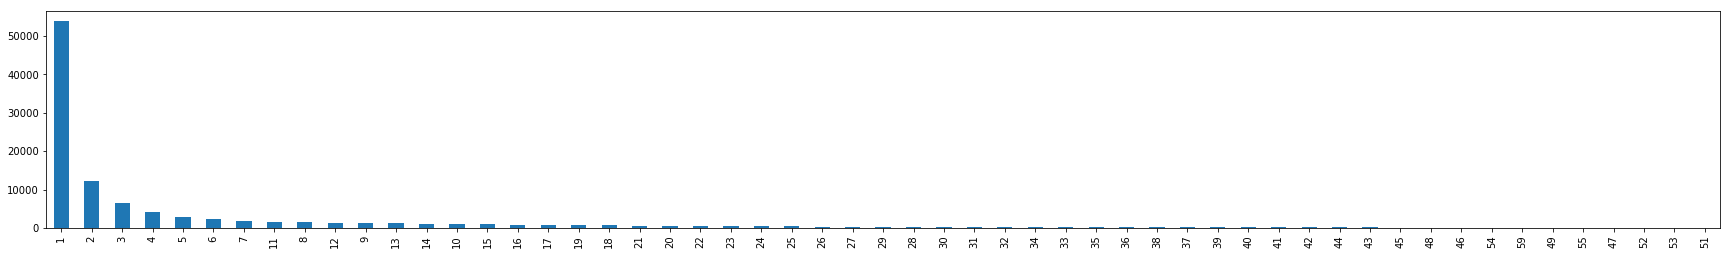

In [22]:
tf_matrix_1=pd.DataFrame(list(tf_matrix.items()), columns=['token', 'count_nos'])
min_freq_plot=tf_matrix_1.count_nos.value_counts().sort_values(ascending=False)
min_freq_plot=min_freq_plot[0:int(.05*min_freq_plot.shape[0])]
plt.subplots(figsize=(30,4))
min_freq_plot.plot.bar()
plt.show()

In [23]:
min_freq_plot=tf_matrix_1.count_nos.value_counts().sort_values(ascending=False)
min_freq_plot

1       53921
2       12330
3        6492
4        4136
5        2974
6        2317
7        1865
11       1540
8        1500
12       1369
9        1347
13       1311
14       1123
10       1104
15       1019
16        922
17        841
19        719
18        707
21        605
20        586
22        519
23        496
24        443
25        425
26        403
27        368
29        351
28        333
30        284
        ...  
1968        1
1267        1
5234        1
880         1
2607        1
622         1
686         1
750         1
814         1
942         1
7341        1
1326        1
2414        1
8811        1
623         1
687         1
879         1
1007        1
5165        1
1199        1
1327        1
496         1
816         1
1136        1
468         1
9979        1
1225        1
1224        1
1352        1
2782        1
Name: count_nos, Length: 1111, dtype: int64

In [24]:
freq_word=tf_matrix_1.sort_values(by='count_nos',ascending=False)
freq_word.head(15)

,token,count_nos
69018,"""",63474
41760,movie,42908
93017,film,40394
57707,one,22054
74281,just,15948
110319,!,15576
10241,like,14562
91156,?,12479
35837,character,10396
49389,even,10373


In [25]:
texts_2 = [[token for token in text if tf_matrix[token] > 10 and tf_matrix[token]<22000] for text in texts_1]

In [26]:
tf_matrix_2 = defaultdict(int)

## token count in corpus
for text in texts_2:
     for token in text:
         tf_matrix_2[token] += 1

In [27]:
tf_matrix_2=pd.DataFrame(list(tf_matrix_2.items()), columns=['token', 'count_nos'])
print(tf_matrix_2.shape)

(24835, 2)


In [28]:
tf_matrix_2.head(15)

,token,count_nos
0,waiting_something,13
1,sonja,13
2,bottom_list,12
3,burgade,18
4,hanging,179
5,woody,76
6,early_role,19
7,comically,24
8,chatter,15
9,give_solid_performance,12


In [29]:
min_word_len= [[token for token in doc if len(token)<=2]for doc in texts_2]
tf_matrix_3 = defaultdict(int)

In [30]:
## token count in corpus
for text in min_word_len:
     for token in text:
         tf_matrix_3[token] += 1
tf_matrix_3=pd.DataFrame(list(tf_matrix_3.items()), columns=['token', 'count_nos'])
tf_matrix_3=tf_matrix_3.sort_values(by='count_nos',ascending=False)
print(tf_matrix_3.shape)

(205, 2)


In [31]:
list(tf_matrix_3.token)

[u'!',
 u'?',
 u'-',
 u';',
 u'go',
 u'&',
 u'u',
 u'--',
 u'le',
 u'mr',
 u'\x96',
 u'tv',
 u'ok',
 u'oh',
 u"'",
 u'dr',
 u'us',
 u'b',
 u'm',
 u'de',
 u'e',
 u'dy',
 u'la',
 u'v',
 u's',
 u'c',
 u'd',
 u'/',
 u'r',
 u'uk',
 u'l',
 u'ii',
 u'p',
 u'j',
 u'80',
 u't',
 u'o',
 u'as',
 u'al',
 u'*',
 u'f',
 u'ad',
 u'ed',
 u'g',
 u'70',
 u'jr',
 u'x',
 u'w',
 u'k',
 u'bo',
 u'h',
 u'n',
 u'ah',
 u'fx',
 u'60',
 u'cd',
 u'=',
 u'st',
 u'ex',
 u'ya',
 u"'s",
 u'cg',
 u'3d',
 u'**',
 u'\u2013',
 u'co',
 u'q',
 u'da',
 u'50',
 u'im',
 u'$1',
 u'hk',
 u'#1',
 u'~',
 u'+',
 u'90',
 u'uh',
 u'ie',
 u'ho',
 u'z',
 u'y',
 u'30',
 u'id',
 u'sf',
 u'\x97',
 u'pc',
 u'um',
 u'el',
 u're',
 u"'i",
 u'te',
 u'40',
 u'pg',
 u'iq',
 u'ny',
 u'du',
 u'et',
 u'#2',
 u'ma',
 u'un',
 u'er',
 u'oz',
 u"'a",
 u'iv',
 u'jo',
 u'dj',
 u'pa',
 u'$5',
 u'en',
 u'lt',
 u'ha',
 u'li',
 u'ta',
 u'he',
 u'wb',
 u'hi',
 u'mj',
 u'pb',
 u'wu',
 u"o'",
 u'di',
 u'ax',
 u'$3',
 u'ca',
 u'il',
 u'eg',
 u'em',
 u'lo',
 u'

In [32]:
two_len_word=['!','?','go','tv','ok','oh','hr','ah']
texts_3= [[token for token in doc if len(token)>2 or token in two_len_word]for doc in texts_2]

In [33]:
texts_3[:10]

[[u'high',
  u'cartoon',
  u'comedy',
  u'ran',
  u'time',
  u'program',
  u'school',
  u'life',
  u'teacher',
  u'year',
  u'teaching',
  u'profession',
  u'lead_believe',
  u'satire',
  u'much_closer',
  u'reality',
  u'teacher',
  u'survive',
  u'financially',
  u'insightful',
  u'student',
  u'see',
  u'right',
  u'pathetic',
  u'whole',
  u'situation',
  u'remind',
  u'school',
  u'knew',
  u'student',
  u'saw',
  u'episode',
  u'student',
  u'repeatedly',
  u'tried',
  u'burn',
  u'school',
  u'immediately',
  u'recalled',
  u'high',
  u'classic',
  u'line',
  u'inspector',
  u'sack',
  u'teacher',
  u'student',
  u'welcome',
  u'high',
  u'expect',
  u'many',
  u'adult',
  u'age',
  u'think',
  u'high',
  u'far_fetched',
  u'pity',
  u'!'],
 [u'george',
  u'stated',
  u'issue',
  u'year',
  u'never',
  u'plan',
  u'help',
  u'street',
  u'considered',
  u'human',
  u'everything',
  u'going',
  u'school',
  u'work',
  u'vote',
  u'matter',
  u'people',
  u'think',
  u'homeless',


In [34]:
tf_matrix_4 = defaultdict(int)

## token count in corpus
for text in texts_3:
     for token in text:
         tf_matrix_4[token] += 1
tf_matrix_4=pd.DataFrame(list(tf_matrix_4.items()), columns=['token', 'count_nos'])
print(tf_matrix_4.shape)

(24638, 2)


In [35]:
dictionary = corpora.Dictionary(texts_3)
corpus = [dictionary.doc2bow(text) for text in texts_3]
tfidf=models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [36]:
from gensim.matutils import corpus2csc
from scipy.sparse import csc_matrix

In [37]:
scipy_csc_matrix = corpus2csc(corpus_tfidf)
full_matrix = csc_matrix(scipy_csc_matrix)
full_matrix.shape
DTM=full_matrix.T

In [38]:
dictionary[0]

u'program'

In [39]:
token_mapping=pd.DataFrame.from_dict(dictionary.id2token,orient='index')
token_mapping.columns=["Token"]

In [40]:
y = np.concatenate((np.ones(len(pos_review)), np.zeros(len(neg_review))))

In [42]:
x_train, x_test, y_train, y_test = train_test_split(DTM, y, test_size=0.2)

In [44]:
model=SGDClassifier(loss='hinge', penalty='l2',max_iter=50,random_state =6)

In [45]:
_=model.fit(x_train,y_train)

In [46]:
train_pred=model.predict(x_train)

In [47]:
accuracy_score(y_train,train_pred)

0.95474999999999999

In [48]:
test_pred=model.predict(x_test)

In [49]:
print("Accuracy")
accuracy_score(y_test,test_pred)

Accuracy


0.89239999999999997

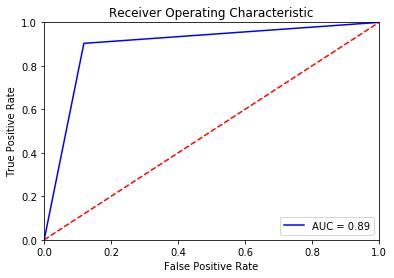

In [50]:
##...ROC Curve

fpr,tpr,_=roc_curve(y_test,test_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()